In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.stats as stats
import os 
import h5py
import sys
import re
import xgboost as xgb 
import sklearn.multioutput

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'boxcox', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 7.958078640513122e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(80000, 44) (80000, 12)
(20000, 44) (20000, 12)


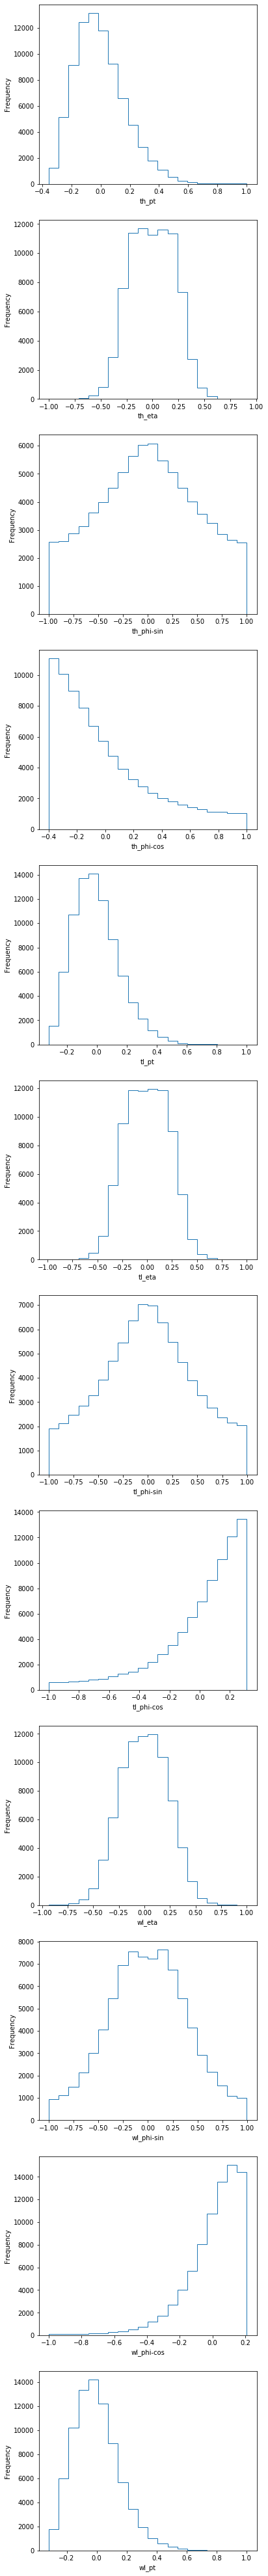

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

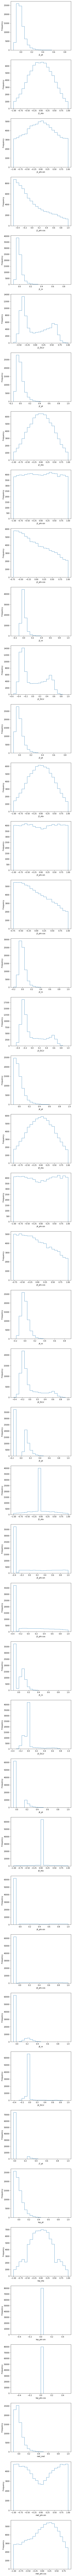

In [5]:
# Histograms of X variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
Dtrain = xgb.DMatrix(trainX, label=trainY)
Dtest = xgb.DMatrix(testX, label=testY)

model = sklearn.multioutput.MultiOutputRegressor(xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 8, alpha = 1, n_estimators = 512, verbosity=2))

# model = sklearn.multioutput.MultiOutputRegressor(xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1))

In [7]:
model.fit(trainX,trainY)

/home/hongtao/anaconda3/envs/top-ml/lib/python3.7/site-packages/xgboost/core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[16:30:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[16:30:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:30:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[16:30:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=8
[16:30:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:30:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=8
[16:30:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[16:30:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:30:42] INFO: /workspace/src/

[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=8
[16:30:47] INFO: /workspace/src/

[16:30:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=8
[16:30:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:30:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:30:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=8
[16:30:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=8
[16:30:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=8
[16:30:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=8
[16:30:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=8
[16:30:54] INFO: /workspace/src/

[16:30:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=8
[16:30:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=8
[16:30:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[16:30:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=8
[16:30:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[16:30:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=8
[16:30:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:31:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:31:00] INFO: /workspace/src/

[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=8
[16:31:05] INFO: /workspace/src/

[16:31:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:31:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=8
[16:31:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:31:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=8
[16:31:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=8
[16:31:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:31:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=8
[16:31:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[16:31:11] INFO: /workspace/src/

[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=8
[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=8
[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[16:31:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=8
[16:31:18] INFO: /workspace/src/

[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=8
[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=8
[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=8
[16:31:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=8
[16:31:24] INFO: /workspace/src/

[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=8
[16:31:29] INFO: /workspace/src/

[16:31:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:31:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[16:31:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:31:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[16:31:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[16:31:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=8
[16:31:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:31:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:31:36] INFO: /workspace/src/

[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[16:31:41] INFO: /workspace/src/

[16:31:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:31:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:31:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=8
[16:31:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=8
[16:31:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[16:31:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=8
[16:31:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=8
[16:31:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=8
[16:31:47] INFO: /workspace/src/

[16:31:52] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=8
[16:31:53] INFO: /workspace/src/

[16:31:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:31:58] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[16:31:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=8
[16:31:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[16:31:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=8
[16:31:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=8
[16:31:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:31:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=8
[16:31:59] INFO: /workspace/src/

[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:32:05] INFO: /workspace/src/

[16:32:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=8
[16:32:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=8
[16:32:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=8
[16:32:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=8
[16:32:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=8
[16:32:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=8
[16:32:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=8
[16:32:11] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=8
[16:32:11] INFO: /workspace/src/

[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=8
[16:32:17] INFO: /workspace/src/

[16:32:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[16:32:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:32:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=8
[16:32:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=8
[16:32:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=8
[16:32:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:32:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=8
[16:32:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[16:32:24] INFO: /workspace/src/

[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=8
[16:32:30] INFO: /workspace/src/

[16:32:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:32:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=8
[16:32:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[16:32:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:32:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=8
[16:32:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=8
[16:32:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=8
[16:32:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=8
[16:32:37] INFO: /workspace/src/

[16:32:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=8
[16:32:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[16:32:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:32:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[16:32:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=8
[16:32:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=8
[16:32:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[16:32:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=8
[16:32:43] INFO: /workspace/src/

[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:32:49] INFO: /workspace/src/

[16:32:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[16:32:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=8
[16:32:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[16:32:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=8
[16:32:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:32:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:32:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:32:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[16:32:55] INFO: /workspace/src/

[16:33:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=8
[16:33:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=8
[16:33:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=8
[16:33:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=8
[16:33:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=8
[16:33:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=8
[16:33:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 502 extra nodes, 0 pruned nodes, max_depth=8
[16:33:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=8
[16:33:02] INFO: /workspace/src/

[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=8
[16:33:07] INFO: /workspace/src/

[16:33:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=8
[16:33:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:33:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[16:33:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:33:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=8
[16:33:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[16:33:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:33:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=8
[16:33:14] INFO: /workspace/src/

[16:33:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=8
[16:33:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[16:33:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[16:33:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[16:33:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[16:33:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=8
[16:33:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[16:33:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:33:20] INFO: /workspace/src/t

[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:33:26] INFO: /workspace/src/

[16:33:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:33:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=8
[16:33:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[16:33:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=8
[16:33:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[16:33:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=8
[16:33:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[16:33:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=8
[16:33:32] INFO: /workspace/src/

[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=8
[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:33:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[16:33:39] INFO: /workspace/src/

[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[16:33:44] INFO: /workspace/src/

[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[16:33:50] INFO: /workspace/src/

[16:33:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[16:33:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=8
[16:33:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:33:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[16:33:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=8
[16:33:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:33:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=8
[16:33:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:33:57] INFO: /workspace/src/

[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:34:03] INFO: /workspace/src/

[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=8
[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=8
[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=8
[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=8
[16:34:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=8
[16:34:10] INFO: /workspace/src/

[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:34:15] INFO: /workspace/src/

[16:34:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:34:22] INFO: /workspace/src/

[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=8
[16:34:28] INFO: /workspace/src/

[16:34:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:34:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[16:34:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[16:34:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=8
[16:34:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[16:34:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=8
[16:34:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[16:34:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:34:35] INFO: /workspace/src/

[16:34:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[16:34:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=8
[16:34:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[16:34:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:34:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[16:34:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[16:34:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[16:34:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[16:34:41] INFO: /workspace/src/

[16:34:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=8
[16:34:47] INFO: /workspace/src/

[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=8
[16:34:53] INFO: /workspace/src/

[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=8
[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:34:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=8
[16:35:00] INFO: /workspace/src/

[16:35:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:35:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=8
[16:35:05] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[16:35:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=8
[16:35:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[16:35:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[16:35:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:35:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=8
[16:35:06] INFO: /workspace/src/

[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=8
[16:35:12] INFO: /workspace/src/

[16:35:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=8
[16:35:18] INFO: /workspace/src/

[16:35:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=8
[16:35:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=8
[16:35:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=8
[16:35:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:35:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=8
[16:35:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[16:35:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[16:35:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=8
[16:35:25] INFO: /workspace/src/

[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:35:30] INFO: /workspace/src/

[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[16:35:36] INFO: /workspace/src/

[16:35:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[16:35:42] INFO: /workspace/src/

[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=8
[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=8
[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=8
[16:35:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:35:49] INFO: /workspace/src/

[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=8
[16:35:54] INFO: /workspace/src/

[16:36:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:36:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[16:36:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[16:36:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:36:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:36:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=8
[16:36:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:36:01] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=8
[16:36:01] INFO: /workspace/src/

[16:36:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=8
[16:36:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=8
[16:36:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[16:36:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[16:36:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=8
[16:36:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:36:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[16:36:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=8
[16:36:07] INFO: /workspace/src/

[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=8
[16:36:13] INFO: /workspace/src/

[16:36:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[16:36:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:36:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=8
[16:36:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=8
[16:36:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=8
[16:36:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=8
[16:36:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=8
[16:36:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=8
[16:36:19] INFO: /workspace/src/

[16:36:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=8
[16:36:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[16:36:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=8
[16:36:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=8
[16:36:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[16:36:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=8
[16:36:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:36:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:36:26] INFO: /workspace/src/

[16:36:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=8
[16:36:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:36:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=8
[16:36:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[16:36:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=8
[16:36:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:36:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=8
[16:36:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=8
[16:36:32] INFO: /workspace/src/

[16:36:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=8
[16:36:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:36:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[16:36:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=8
[16:36:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=8
[16:36:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:36:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:36:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=8
[16:36:38] INFO: /workspace/src/

[16:36:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=8
[16:36:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=8
[16:36:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[16:36:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:36:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[16:36:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=8
[16:36:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=8
[16:36:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=8
[16:36:44] INFO: /workspace/src/

[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[16:36:50] INFO: /workspace/src/

[16:36:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=8
[16:36:56] INFO: /workspace/src/

[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[16:37:02] INFO: /workspace/src/

[16:37:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:37:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:37:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=8
[16:37:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:37:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=8
[16:37:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=8
[16:37:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=8
[16:37:09] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=8
[16:37:09] INFO: /workspace/src/

[16:37:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[16:37:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=8
[16:37:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:37:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=8
[16:37:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[16:37:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=8
[16:37:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=8
[16:37:15] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=8
[16:37:15] INFO: /workspace/src/

[16:37:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:37:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:37:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:37:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:37:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:37:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=8
[16:37:21] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=8
[16:37:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=8
[16:37:22] INFO: /workspace/src/

[16:37:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:37:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=8
[16:37:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:37:27] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=8
[16:37:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:37:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=8
[16:37:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8
[16:37:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=8
[16:37:28] INFO: /workspace/src/

[16:37:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=8
[16:37:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[16:37:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:37:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=8
[16:37:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=8
[16:37:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[16:37:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=8
[16:37:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=8
[16:37:35] INFO: /workspace/src/

[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[16:37:40] INFO: /workspace/src/

[16:37:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=8
[16:37:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[16:37:46] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:37:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[16:37:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[16:37:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=8
[16:37:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:37:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[16:37:47] INFO: /workspace/src/

[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=8
[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=8
[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=8
[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=8
[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=8
[16:37:53] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=8
[16:37:54] INFO: /workspace/src/

[16:37:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=8
[16:37:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[16:37:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:37:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[16:37:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=8
[16:37:59] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[16:38:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:38:00] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=8
[16:38:00] INFO: /workspace/src/

[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=8
[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=8
[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[16:38:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:38:07] INFO: /workspace/src/

[16:38:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=8
[16:38:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=8
[16:38:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:38:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=8
[16:38:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[16:38:12] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=8
[16:38:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=8
[16:38:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:38:13] INFO: /workspace/src/

[16:38:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:38:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=8
[16:38:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:38:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:38:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=8
[16:38:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=8
[16:38:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:38:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=8
[16:38:19] INFO: /workspace/src/

[16:38:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[16:38:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[16:38:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[16:38:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=8
[16:38:24] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=8
[16:38:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=8
[16:38:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=8
[16:38:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:38:25] INFO: /workspace/src/

[16:38:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[16:38:30] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=8
[16:38:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[16:38:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[16:38:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=8
[16:38:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:38:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=8
[16:38:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:38:31] INFO: /workspace/src/

[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=8
[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=8
[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=8
[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:38:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=8
[16:38:38] INFO: /workspace/src/

[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=8
[16:38:43] INFO: /workspace/src/

[16:38:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[16:38:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=8
[16:38:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[16:38:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=8
[16:38:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:38:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=8
[16:38:49] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[16:38:50] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:38:50] INFO: /workspace/src/

[16:38:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:38:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=8
[16:38:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:38:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=8
[16:38:55] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=8
[16:38:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=8
[16:38:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=8
[16:38:56] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=8
[16:38:56] INFO: /workspace/src/

[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=8
[16:39:02] INFO: /workspace/src/

[16:39:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:39:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:39:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[16:39:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=8
[16:39:07] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[16:39:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[16:39:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:39:08] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=8
[16:39:08] INFO: /workspace/src/

[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=8
[16:39:14] INFO: /workspace/src/

[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=8
[16:39:20] INFO: /workspace/src/

[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=8
[16:39:26] INFO: /workspace/src/

[16:39:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:39:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[16:39:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=8
[16:39:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=8
[16:39:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=8
[16:39:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[16:39:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=8
[16:39:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=8
[16:39:33] INFO: /workspace/src/

[16:39:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[16:39:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=8
[16:39:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=8
[16:39:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[16:39:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[16:39:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=8
[16:39:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=8
[16:39:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=8
[16:39:39] INFO: /workspace/src/

[16:39:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=8
[16:39:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=8
[16:39:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=8
[16:39:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=8
[16:39:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[16:39:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=8
[16:39:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=8
[16:39:45] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=8
[16:39:45] INFO: /workspace/src/

[16:39:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=8
[16:39:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=8
[16:39:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[16:39:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=8


MultiOutputRegressor(estimator=XGBRegressor(alpha=1, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.05,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=512, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:squarederro

In [8]:
predictions = model.predict(testX)

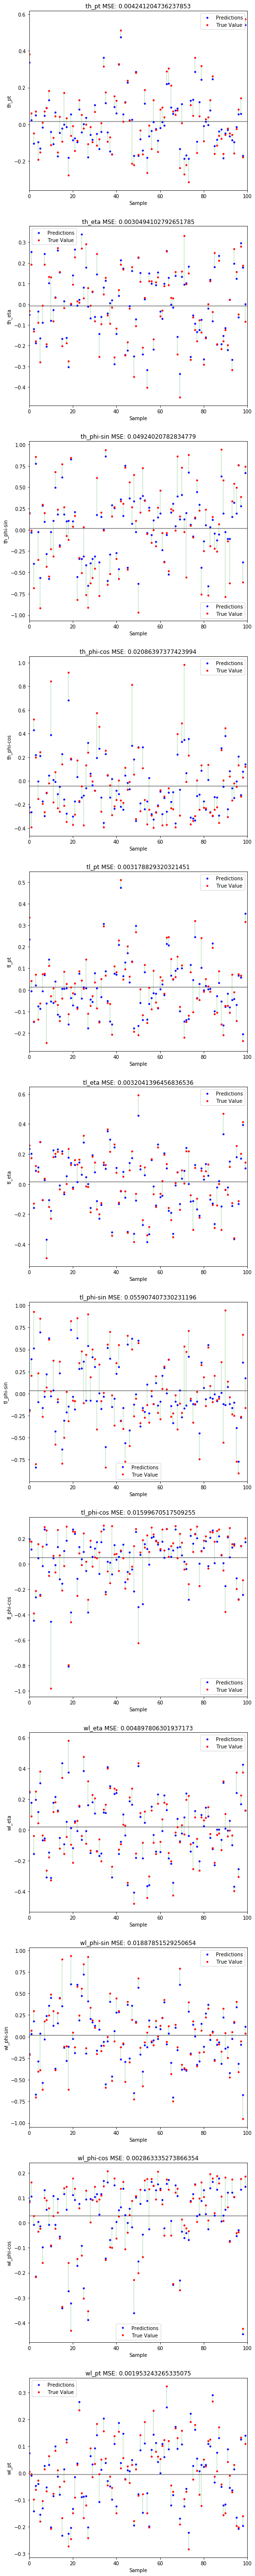

In [32]:
Y_length_orig = Y_length
Y_length  = trainY.shape[1]

# Training 
crop = 100 

train_small = model.predict(trainX[0:100,:])
Y_small = trainY[0:100,:]


def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*Y_length))
    for i in range(0,Y_length):
        plt.subplot(Y_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Sample')
        plt.ylabel(Y_names[i])
        plt.xlim(0, crop)
        plt.title(Y_names[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, Y_small)

In [33]:
# Predictions

predictions_small = predictions[0:100,:]
testY_small = testY[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- testY)**2)
print("total MSE: " + str(MSE))

for i in range(Y_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -testY[:,i])**2)
    print("{0} MSE : ".format(Y_names[i]), '%.10f'%MSE)

total MSE: 0.042371819780318315
th_pt MSE :  0.0090607544
th_eta MSE :  0.0102937463
th_phi-sin MSE :  0.1603076264
th_phi-cos MSE :  0.0690135238
tl_pt MSE :  0.0060014090
tl_eta MSE :  0.0088032072
tl_phi-sin MSE :  0.1251850607
tl_phi-cos MSE :  0.0411544788
wl_eta MSE :  0.0084384388
wl_phi-sin MSE :  0.0549453493
wl_phi-cos MSE :  0.0109720024
wl_pt MSE :  0.0042862402


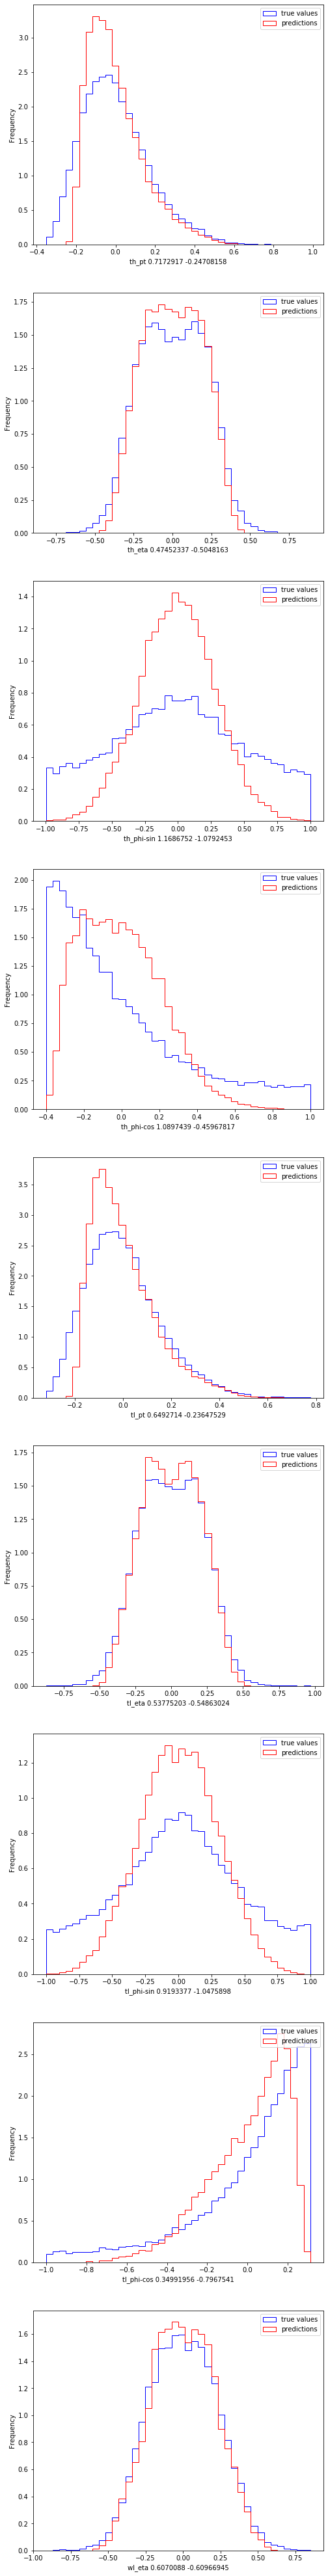

In [42]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(testY[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_names[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

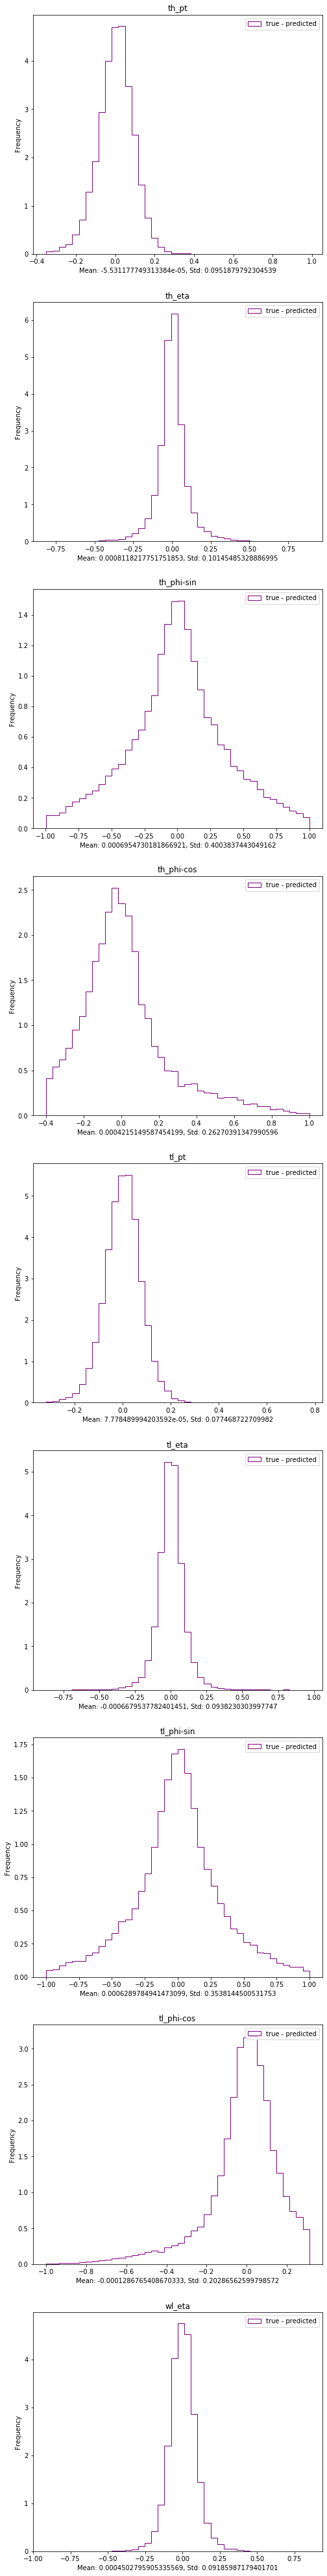

In [44]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_names[i])
    plt.legend()
    plt.ylabel('Frequency')

In [36]:
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)
out_scaled = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

total_predictions = model.predict(X_total)
predict_scaled = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]

Y_length = Y_length_orig

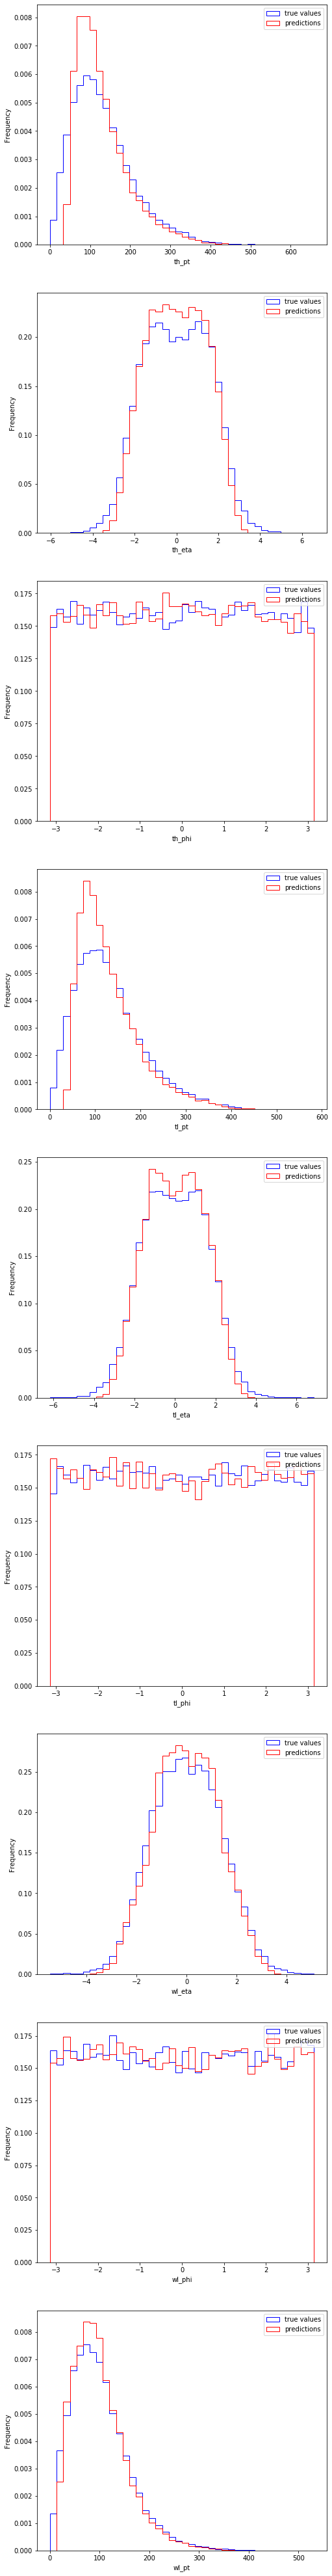

In [37]:
# Histograms to the original scale 


plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    hist, edges = np.histogram(out_scaled[:, i], 40)
    plt.hist(out_scaled[:, i], edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

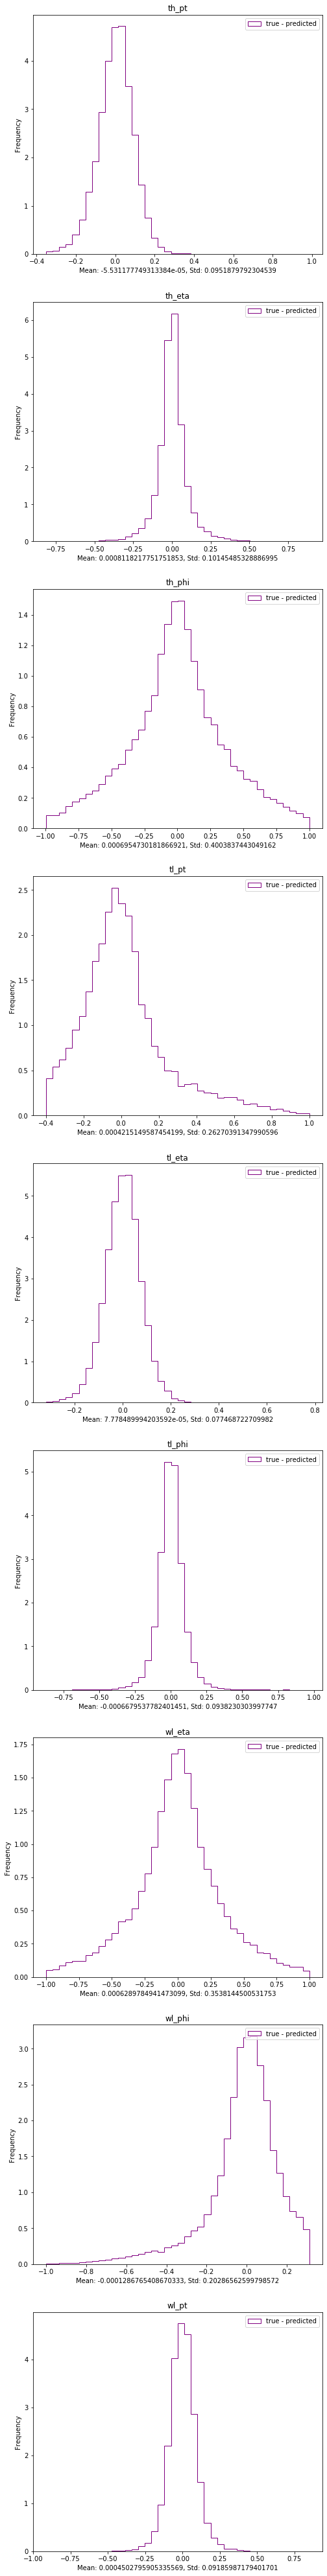

In [38]:
# True - Predicted 

plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    diff = testY[:,i] - predictions[:,i]
    hist0, bin_edges = np.histogram(testY[:, i], bins=40)
    plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

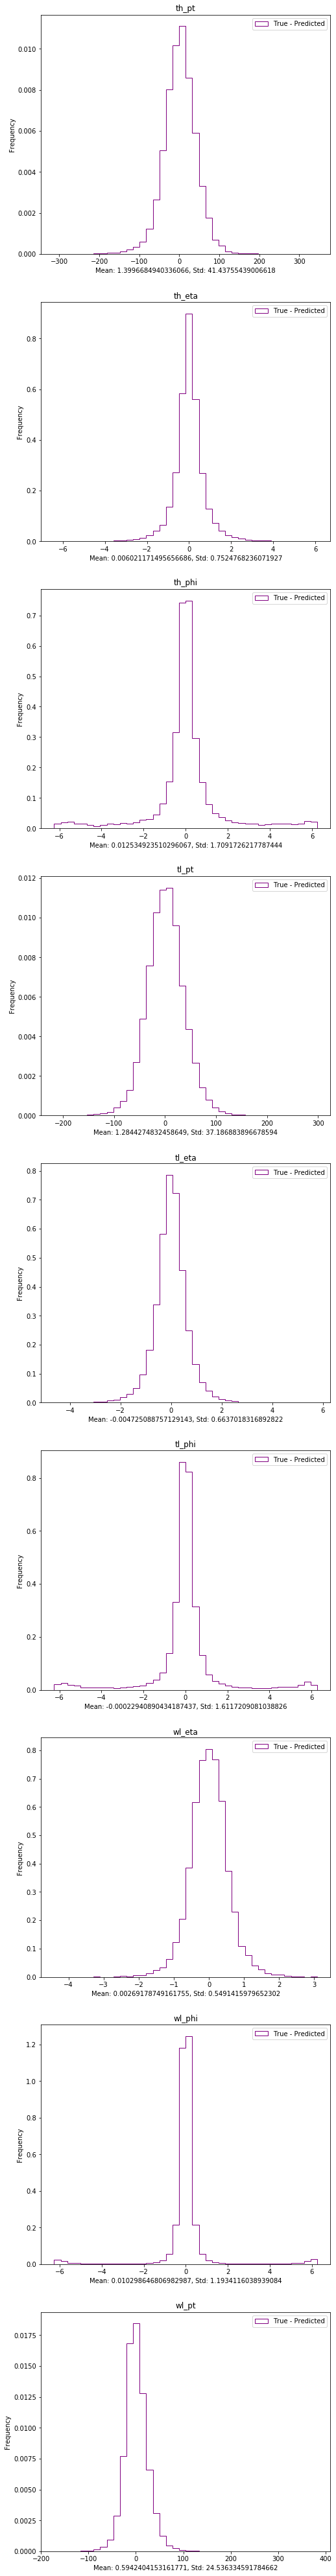

In [39]:
# Difference value histograms 
plt.figure(figsize=(8,8*Y_length))
for i in range(len(Y_keys)):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    diff = -predict_scaled[:, i]+out_scaled[:, i]
    plt.hist(diff, 40, histtype='step', color='purple', label='True - Predicted', density=True)
    plt.xlabel("Mean: {0}, Std: {1}".format(np.mean(diff), np.std(diff)))
    plt.title(Y_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [40]:
for i in range(Y_length):
    if Y_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(Y_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1719.0299857229
Original Scale th_eta MSE :  0.5662576246
Original Scale th_phi MSE :  0.8635248140
Original Scale tl_pt MSE :  1384.5140879048
Original Scale tl_eta MSE :  0.4405224479
Original Scale tl_phi MSE :  0.5760769774
Original Scale wl_eta MSE :  0.3015637403
Original Scale wl_phi MSE :  0.1867985590
Original Scale wl_pt MSE :  602.3848368712


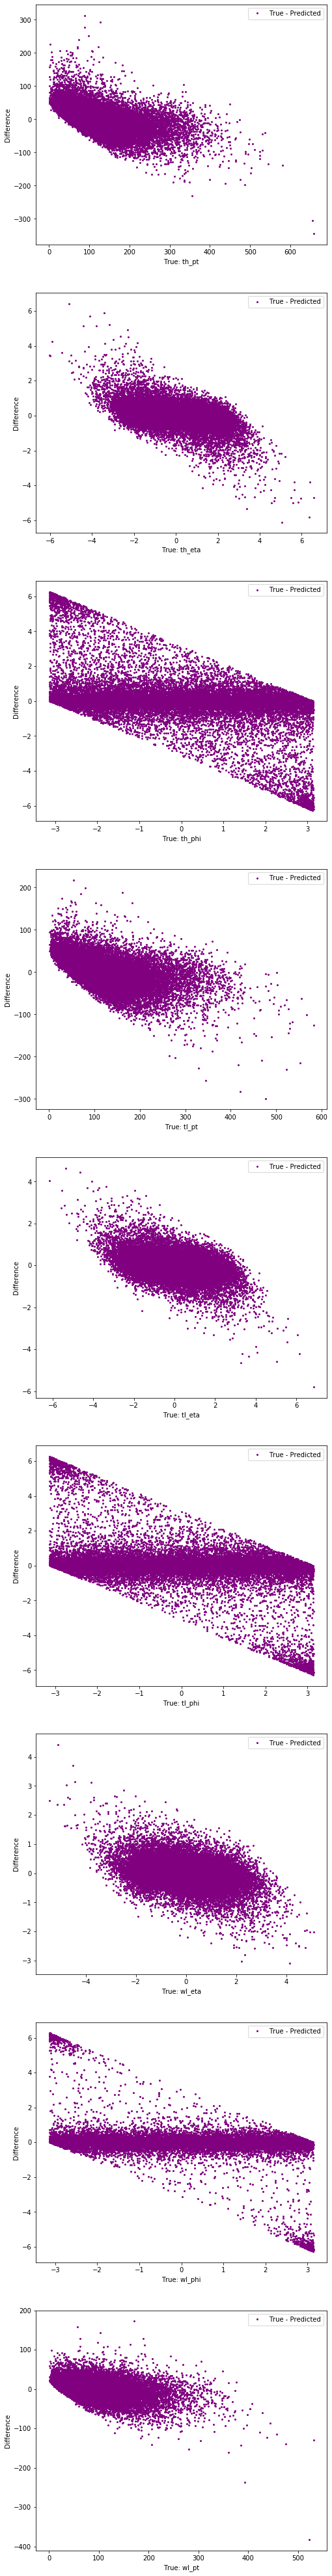

In [41]:
plt.figure(figsize=(8,8*Y_length))
for i in range(Y_length):
    plt.subplot(Y_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + Y_keys[i])
    plt.legend()
    plt.ylabel('Difference')